**Загрузка и подготовка данных**

In [1]:
import pandas as pd
import random
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
DF = pd.read_csv('/content/hotel_balanced.csv',encoding='utf-8',lineterminator='\n')[['text','label']]
DF1 = pd.read_csv('/content/phone_balanced.csv',encoding='utf-8',lineterminator='\n')[['text','label']]
DF2 = pd.read_csv('/content/reviews_balanced.csv',encoding='utf-8',lineterminator='\n')[['text','label']]
DF3 = pd.read_csv('/content/women_balanced.csv',encoding='utf-8',lineterminator='\n')[['text','label']]

lenth = min(len(DF),len(DF1),len(DF2),len(DF3))
DF = DF.iloc[:lenth]
DF1 = DF1.iloc[:lenth]
DF2 = DF2.iloc[:lenth]
DF3 = DF3.iloc[:lenth]

hotel_data = DF.drop_duplicates()
hotel_data = DF.dropna()

phone_data = DF1.drop_duplicates()
phone_data = DF1.dropna()

reviews_data = DF2.drop_duplicates()
reviews_data = DF2.dropna()

women_data = DF3.drop_duplicates()
women_data = DF3.dropna()

In [3]:
train_text_hotel, test_text_hotel, train_labels_hotel, test_labels_hotel = train_test_split(hotel_data[['text']], hotel_data[['label']], test_size=0.2, random_state=42)
train_text_hotel, val_text_hotel, train_labels_hotel, val_labels_hotel = train_test_split(train_text_hotel, train_labels_hotel, test_size=0.25, random_state=42)

train_text_phone, test_text_phone, train_labels_phone, test_labels_phone = train_test_split(phone_data[['text']], phone_data[['label']], test_size=0.2, random_state=42)
train_text_phone, val_text_phone, train_labels_phone, val_labels_phone = train_test_split(train_text_phone, train_labels_phone, test_size=0.25, random_state=42)

train_text_reviews, test_text_reviews, train_labels_reviews, test_labels_reviews = train_test_split(reviews_data[['text']], reviews_data[['label']], test_size=0.2, random_state=42)
train_text_reviews, val_text_reviews, train_labels_reviews, val_labels_reviews = train_test_split(train_text_reviews, train_labels_reviews, test_size=0.25, random_state=42)

train_text_women, test_text_women, train_labels_women, test_labels_women = train_test_split(women_data[['text']], women_data[['label']], test_size=0.2, random_state=42)
train_text_women, val_text_women, train_labels_women, val_labels_women = train_test_split(train_text_women, train_labels_women, test_size=0.25, random_state=42)

In [4]:
main_train_data_text = pd.concat([train_text_hotel,train_text_phone,train_text_reviews,train_text_women], ignore_index=True)
main_train_data_labels = pd.concat([train_labels_hotel,train_labels_phone,train_labels_reviews,train_labels_women], ignore_index=True)

main_val_data_text = pd.concat([val_text_hotel,val_text_phone,val_text_reviews,val_text_women])
main_val_data_labels = pd.concat([val_labels_hotel,val_labels_phone,val_labels_reviews,val_labels_women])

main_test_data_text = pd.concat([test_text_hotel,test_text_phone,test_text_reviews,test_text_women])
main_test_data_labels = pd.concat([test_labels_hotel,test_labels_phone,test_labels_reviews,test_labels_women])

In [5]:
main_train_data = main_train_data_text
main_train_data['label'] = main_train_data_labels
main_train_data = main_train_data.sample(frac=1).reset_index(drop=True)
main_train_data.to_csv('main_train_data.csv')

main_val_data = main_val_data_text
main_val_data['label'] = main_val_data_labels
main_val_data = main_val_data.sample(frac=1).reset_index(drop=True)
main_val_data.to_csv('main_val_data.csv')

main_test_data = main_test_data_text
main_test_data['label'] = main_test_data_labels
main_test_data = main_test_data.sample(frac=1).reset_index(drop=True)
main_test_data.to_csv('main_test_data.csv')

In [6]:
main_train_data = pd.read_csv('/content/drive/MyDrive/balanced_data/main_train_data.csv',encoding='utf-8',lineterminator='\n')[['text','label']]
main_val_data = pd.read_csv('/content/drive/MyDrive/balanced_data/main_val_data.csv',encoding='utf-8',lineterminator='\n')[['text','label']]
main_test_data = pd.read_csv('/content/reviews_balanced.csv',encoding='utf-8',lineterminator='\n')[['text','label']]

**Подключение библиотек**

In [7]:
!pip install transformers
import torch
from transformers import BertTokenizer, AutoTokenizer, AutoModel

**Загрузка токенизатора с модели Twitter/twhin-bert-base**

In [8]:
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

**График длин отзывов**

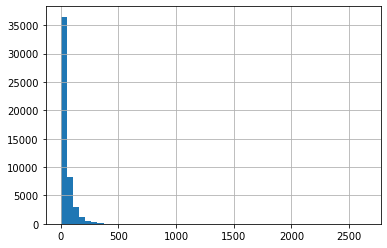

In [9]:
seq_len = [len(str(i).split()) for i in main_train_data['text']]
pd.Series(seq_len).hist(bins = 50)

In [10]:
train_text = main_train_data['text'].astype('str')
train_labels = main_train_data['label'].astype('int')
val_text = main_val_data['text'].astype('str')
val_labels = main_val_data['label'].astype('int')
test_text = main_test_data['text'].astype('str')
test_labels = main_test_data['label'].astype('int')

**Токенизация данных**

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tokens_train = tokenizer.batch_encode_plus(
    list(train_text.values),
    max_length = 240,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    list(val_text.values),
    max_length = 240,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    list(test_text.values),
    max_length = 240,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 32


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq, test_mask)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

**Загружаем модель Twitter/twhin-bert-base, добавляем 3 выхода**

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("Twitter/twhin-bert-base", 
                                                      num_labels = 3, 
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at Twitter/twhin-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-ba

In [13]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
from transformers import get_linear_schedule_with_warmup

n_epochs = 4

n_steps = len(train_dataloader) * n_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = n_steps)

**Дообучение модели на датасете**

In [15]:
from datetime import timedelta
import time
from sklearn.metrics import classification_report
import numpy as np

device = torch.device("cuda")
seed = 42
random.seed = (seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model.cuda()

losses = []

for epoch in range(n_epochs):
    print("Training:")
    start = time.time()
    mean_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        
        torch.cuda.empty_cache()
        if (step + 1) % 100 == 0:
            duration = timedelta(seconds=int(time.time() - start))
            print('Batch {:>5,}  of  {:>5,}.    Time: {:}.'.format(step + 1, len(train_dataloader), duration))
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_targets = batch[2].to(device)
        model.zero_grad()
        
        torch.cuda.empty_cache()
        outputs = model(b_input_ids, attention_mask=b_attention_masks, labels = b_targets)
        loss = outputs[0]
        
        mean_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        mean_loss = mean_loss / len(train_dataloader)
    
    losses.append(mean_loss)
    print("Mean loss: " , mean_loss)
    print("Training epoch took:" , timedelta(seconds=int(time.time() - start)))
    
    print()
    print("Validation:")
    model.eval()
    
    start = time.time()
    predictions = torch.Tensor().to(dtype=torch.int8)
    
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_targets = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_masks, output_hidden_states=False, output_attentions=False, return_dict=True)
        
        predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))
        torch.cuda.empty_cache()
        
    print(classification_report(val_y, predictions))
    print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
    print()

Training:
Batch   100  of  1,570.    Time: 0:02:12.
Batch   200  of  1,570.    Time: 0:04:33.
Batch   300  of  1,570.    Time: 0:06:55.
Batch   400  of  1,570.    Time: 0:09:19.
Batch   500  of  1,570.    Time: 0:11:43.
Batch   600  of  1,570.    Time: 0:14:07.
Batch   700  of  1,570.    Time: 0:16:31.
Batch   800  of  1,570.    Time: 0:18:55.
Batch   900  of  1,570.    Time: 0:21:19.
Batch 1,000  of  1,570.    Time: 0:23:43.
Batch 1,100  of  1,570.    Time: 0:26:07.
Batch 1,200  of  1,570.    Time: 0:28:31.
Batch 1,300  of  1,570.    Time: 0:30:55.
Batch 1,400  of  1,570.    Time: 0:33:19.
Batch 1,500  of  1,570.    Time: 0:35:43.
Mean loss:  0.0005728944481773934
Training epoch took: 0:37:25

Validation:
              precision    recall  f1-score   support

           0       0.55      0.68      0.61      5607
           1       0.82      0.62      0.70      5625
           2       0.76      0.77      0.77      5512

    accuracy                           0.69     16744
   macro avg

**Тестирование модели**

In [16]:
print("Testing:")
model.eval()

t0 = time.time()
predictions = torch.Tensor().to(dtype=torch.int8)

for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_attention_masks = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_masks, output_hidden_states=False, output_attentions=False, return_dict=True)

    predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))

print(classification_report(test_y ,predictions))

Testing:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      7189
           1       0.82      0.88      0.85      6664
           2       0.87      0.84      0.85      7078

    accuracy                           0.81     20931
   macro avg       0.81      0.82      0.81     20931
weighted avg       0.81      0.81      0.81     20931

